In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle
import matplotlib.ticker as plticker
from scipy.signal import find_peaks

plt.rcParams["figure.figsize"] = (15,7)
from numpy.lib.scimath import sqrt as csqrt

#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/media/lucas/datam01/LucasLobo/BRAG-GRATINGS/simulations/python')) #Current directory

from jupyterthemes import jtplot

jtplot.style(theme='onedork', context='notebook', ticks=True, grid=True)
plt.rcParams["figure.figsize"] = (15,7)

def fwhm(x,y):
    from scipy.signal import find_peaks
    peak, pd = find_peaks(y)
    rmax = y[peak[np.argmax(y[peak])]]

    for i in range(0,np.size(x)):

        if y[i] < rmax/2 and y[i+1] > rmax/2:
            halfminindex = i
            break

    for i in range(halfminindex,np.size(x)):
        if y[i] > rmax/2 and y[i+1] < rmax/2:
            halfmaxindex = i
            break
        
    plt.plot(x[halfminindex]*1e9,y[halfminindex],'o',color='r')
    plt.plot(x[halfmaxindex]*1e9,y[halfmaxindex],'o',color='r')
    plt.text(x[int((halfminindex+halfmaxindex)/2)]*1e9,0.97*rmax/2,'FWHM = {}nm'.format(round((x[halfmaxindex]-x[halfminindex])*1e9,3)),color='r',weight='black',fontsize =20,horizontalalignment='center',
        verticalalignment='top')
    plt.plot([x[halfminindex]*1e9,x[halfmaxindex]*1e9],[rmax/2,rmax/2],linestyle='--')
    print('Comprimentos 3 dB: {0} nm e {1} nm'.format(round(x[halfminindex]*1e9,3),round(x[halfmaxindex]*1e9,3)))
    return halfminindex,halfmaxindex


def fwhmlog(x,y):
    from scipy.signal import find_peaks
    peak, pd = find_peaks(y)
    rmax = y[peak[np.argmax(y[peak])]]

    for i in range(0,np.size(x)):

        if y[i] < rmax - 3 and y[i+1] > rmax - 3:
            halfminindex = i
            break

    for i in range(halfminindex,np.size(x)):

        if y[i] > rmax - 3 and y[i+1] < rmax - 3:
            halfmaxindex = i
            break
    plt.plot(x[halfminindex]*1e9,y[halfminindex],'o',color='r')
    plt.plot(x[halfmaxindex]*1e9,y[halfmaxindex],'o',color='r')
    plt.text(x[int((halfminindex+halfmaxindex)/2)]*1e9,1.1*(rmax - 3),'FWHM = {}nm'.format(round((x[halfmaxindex]-x[halfminindex])*1e9,3)),color='r',weight='black',fontsize =20,horizontalalignment='center',
        verticalalignment='top')
    plt.plot([x[halfminindex]*1e9,x[halfmaxindex]*1e9],[rmax - 3,rmax - 3],linestyle='--')
    print('Comprimentos 3 dB: {0} nm e {1} nm'.format(round(x[halfminindex]*1e9,3),round(x[halfmaxindex]*1e9,3)))
    return halfminindex,halfmaxindex


## Calculos Teoricos

Ac index change = 0.00034464258284628733
Aproximação analitica: FWHM = 0.422 nm
Comprimentos 3 dB: 1499.72 nm e 1500.28 nm

Parametros da grade:
Perido da grade = 5.183137525915688e-07nm
numero de periodos = 3858.666666666667
Δn = 0.0005413633031920539


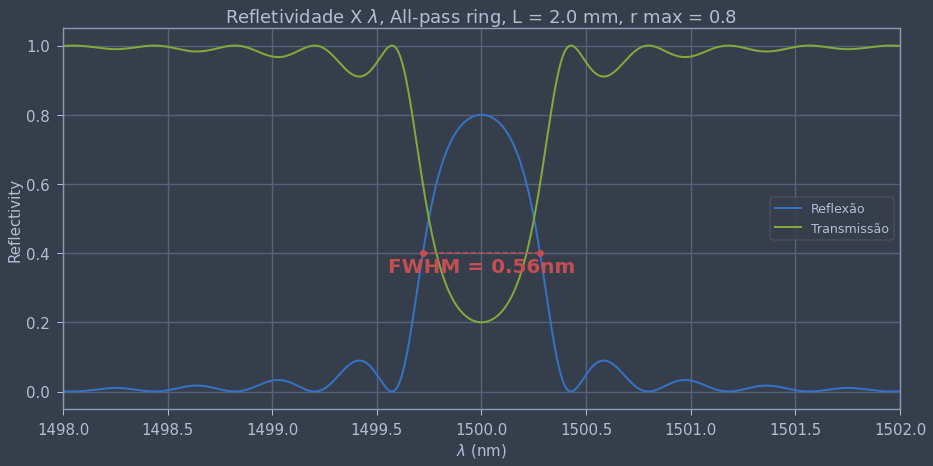

In [5]:
# Constantes

c = 299792458
neff = 1.447
ng = 2.9337
comprimento = np.linspace(1498*1e-9,1502*1e-9,100000)

# Parametros

lambda_ressonancia = 1500e-9
L = 2e-3
rmax = 0.8
periodo = lambda_ressonancia/(2*neff)
n = L/periodo

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

vneff  = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao = abs((np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2))))
print('Ac index change = {}'.format(kappa*lambda_ressonancia/np.pi))


# Zeros da função
bandamin = lambda_ressonancia - vneff/(2*neff)*lambda_ressonancia
bandamax = lambda_ressonancia + vneff/(2*neff)*lambda_ressonancia
largura = vneff/neff*lambda_ressonancia

# Banda de passagem
bandateo = (lambda_ressonancia**2)*np.sqrt(kappa**2+(np.pi/L)**2)/(ng*np.pi)
#print((lambda_ressonancia**2)*np.sqrt(kappa**2+(np.pi/L)**2)/(1.563e-9*np.pi))

#print('Aproximação analitica: Comprimento de corte inferior = {} nm'.format(bandamin*1e9))
#print('Aproximação analitica: Comprimento de corte superior = {} nm'.format(bandamax*1e9))
print('Aproximação analitica: FWHM = {} nm'.format(round((bandateo)*1e9,3)))



plt.plot(comprimento*1e9,reflexao,linewidth=2)
plt.plot(comprimento*1e9,1-reflexao,linewidth=2)
plt.xlim(comprimento[0]*1e9,comprimento[np.size(comprimento)-1]*1e9)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Reflexão','Transmissão'])

#fwhm

halfminindex, halfmaxindex = fwhm(comprimento,reflexao)

print('\n' 'Parametros da grade:')
print('Perido da grade = {}nm'.format(periodo))
print('numero de periodos = {}'.format(n))
print('Δn = {}'.format(kappa*lambda_ressonancia/2))

Comprimentos 3 dB: 1499.22 nm e 1500.781 nm


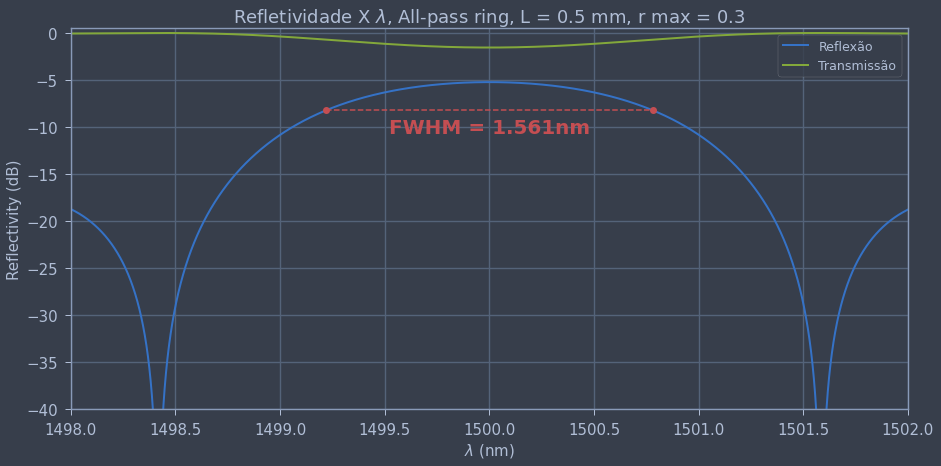

In [10]:
plt.plot(comprimento*1e9,10*np.log10(reflexao),linewidth=2)
plt.plot(comprimento*1e9,10*np.log10(1-reflexao),linewidth=2)
plt.xlim(comprimento[0]*1e9,comprimento[np.size(comprimento)-1]*1e9)
plt.ylim(-40,0.5)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity (dB)',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Reflexão','Transmissão'])

halfminindex, halfmaxindex = fwhmlog(comprimento,10*np.log10(reflexao))

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


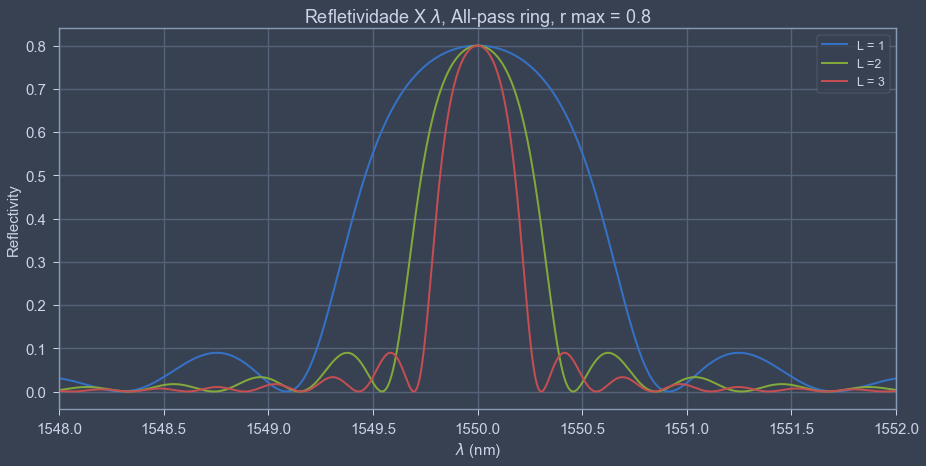

In [28]:
# Constantes

c = 299792458
neff = 1.447
comprimento = np.linspace(1548*1e-9,1552*1e-9,100000)
# Parametros

lambda_ressonancia = 1550e-9
L = 1e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao1 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

lambda_ressonancia = 1550e-9
L = 2e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao2 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

lambda_ressonancia = 1550e-9
L = 3e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao3 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

plt.plot(comprimento*1e9,reflexao1,linewidth=2)
plt.plot(comprimento*1e9,reflexao2,linewidth=2)
plt.plot(comprimento*1e9,reflexao3,linewidth=2)


#plt.plot(comprimento*1e9,10*np.log10(reflexao1),linewidth=2)
#plt.plot(comprimento*1e9,10*np.log10(reflexao2),linewidth=2)
#plt.plot(comprimento*1e9,10*np.log10(reflexao3),linewidth=2)
#plt.ylim(-40,0)
plt.xlim(1548,1552)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, r max = 0.8'.format(L*1e3),fontsize =18)
plt.legend(['L = 1', 'L =2', 'L = 3'])


## Interconnect

In [4]:
inter = lumapi.INTERCONNECT(filename='TheoricSimulations.icp')

dict_keys(['wavelength', 'frequency', 'TE gain (dB)', 'Lumerical_dataset'])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


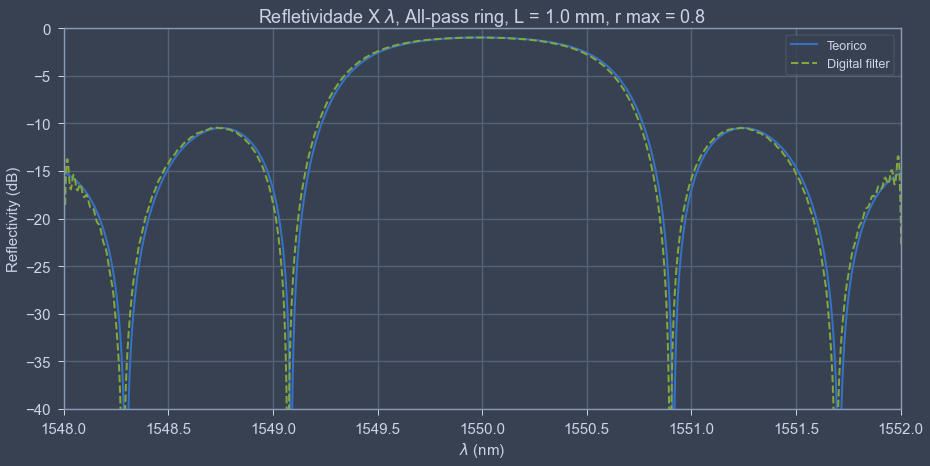

In [18]:
reflexaointer = inter.getresult('ONA_3','input 1/mode 1/gain')
transmissaointer = inter.getresult('ONA_1','input 2/mode 1/gain')
print(reflexaointer.keys())
plt.plot(comprimento*1e9,10*np.log10(reflexao),linewidth=2)
plt.plot(reflexaointer['wavelength']*1e9,reflexaointer['TE gain (dB)'],linewidth=2,linestyle='--')

#plt.plot(transmissaointer['wavelength']*1e9,transmissaointer['TE gain (dB)'])

plt.xlim(1548,1552)
plt.ylim(-40,0)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity (dB)',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Teorico','Digital filter'])

In [31]:
x = np.linspace(0,np.pi,1000)
y = np.sin(x)

peak, peakd = find_peaks(y,rel_height=0.1)
#peakvalue = y[peak]
print(peak)

[499]


# Simulação MODE

336.6120218579235
121187.77798824153
0.09331458905094599


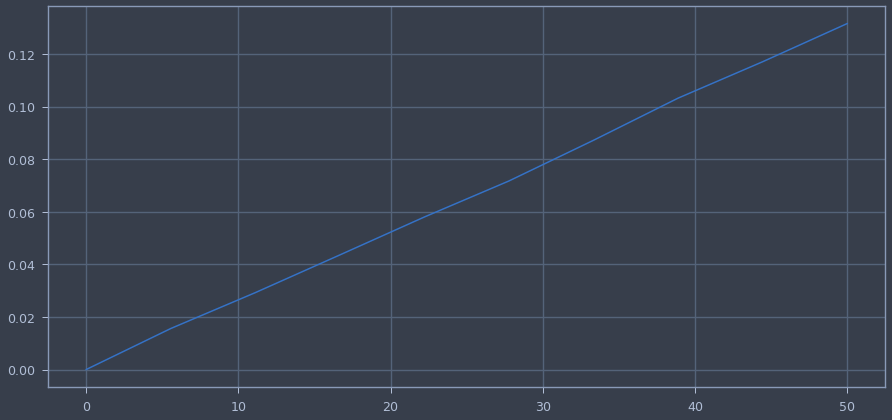

In [16]:
Neff = 2.2875
Ng = 4.5878
comprimentocentral = 1540e-9
Fwhm = 20e-9
N = 1000
periodo = comprimentocentral/(2*Neff)
print(periodo*1e9)
L = periodo*N

kappa = np.sqrt((Fwhm*np.pi*Ng/comprimentocentral**2)**2 - (np.pi/L)**2)
print(kappa)

deltaNeff = kappa*comprimentocentral/2
print(deltaNeff)


neff1 = [2.28787,2.29457,2.30117,2.30833,2.31469,2.32095,2.32884,2.3348,2.34067,2.34705]
neff2 = [2.28787,2.27898,2.27193,2.26475,2.25668,2.24924,2.24166,2.2316,2.22363,2.21549]
deltaw = np.linspace(0,0.05e3,10)
plt.plot(deltaw,np.subtract(neff1,neff2))


In [3]:
mode = lumapi.MODE(filename='bragg.lms')

In [4]:
N = 10
deltaw = np.linspace(0,0.05,N)
neff1 = np.zeros(N)
neff2 = np.zeros(N)
mode.switchtolayout()
mode.setnamed('FDE','x',0.1e-6)

for x in range(N):
    mode.setnamed('bragg','deltaW',deltaw[x]*1e-6)
    mode.findmodes()
    neff1[x] = np.real(mode.getdata('FDE::data::mode1','neff'))
    mode.switchtolayout()

mode.setnamed('FDE','x',0.2e-6)
for x in range(N):
    mode.setnamed('bragg','deltaW',deltaw[x]*1e-6)
    mode.findmodes()
    neff2[x] = np.real(mode.getdata('FDE::data::mode1','neff'))
    mode.switchtolayout()




Text(36, 0.05, '$\\Delta$W=35.4')

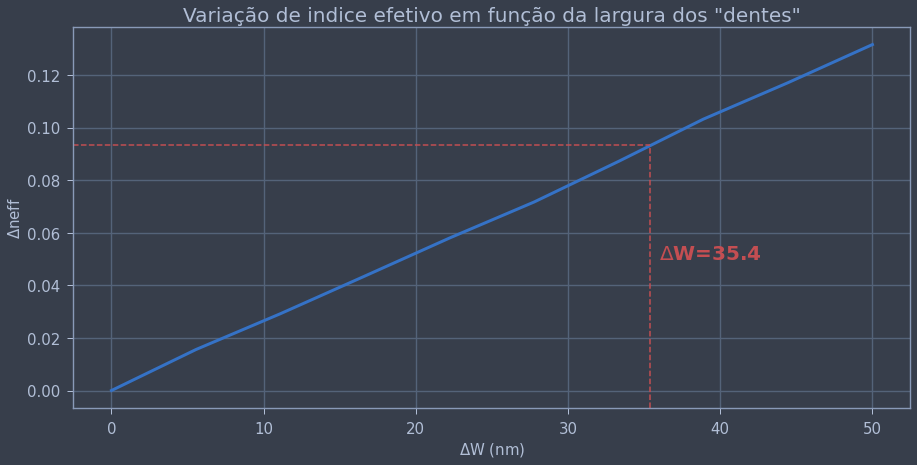

In [64]:
plt.plot(deltaw*1e3,neff1-neff2,linewidth=3)
plt.xlabel(r'$\Delta$W (nm)',fontsize =15)
plt.ylabel(r'$\Delta$neff',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Variação de indice efetivo em função da largura dos "dentes"',fontsize =20)
#plt.legend(['Pass','drop'])
plt.axhline(y=0.0933145890,xmax=0.689,linestyle='--',color = 'r')
plt.axvline(x=35.4,ymax=0.689,linestyle='--',color = 'r')
plt.text(36,0.05,'$\Delta$W=35.4',color='r',weight='black',fontsize =20)
#plt.xlim(33,38)